---
---

PatchTST model

---
---

In [1]:
# imports and global settings
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict

from transformers import (
    PatchTSTConfig,
    PatchTSTForClassification,
    TrainingArguments,
    Trainer,
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [2]:
import pickle as pkl

# File paths and global constants
RAW_TRAIN_DIR = Path("../data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/train/")
RAW_TEST_DIR  = Path("../data/raw/Cleaned SWANSF Dataset/Cleaned SWANSF Dataset/test/")

PARTITIONS_DIR = Path("../data/partitions/")
PARTITIONS_DIR.mkdir(parents=True, exist_ok=True)

NUM_PARTITIONS = 5
NUM_TIMESTEPS  = 60
NUM_FEATURES   = 24

CURRENT_TRAIN_PART = 4
CURRENT_TEST_PART  = 5

FEATURE_NAMES = [
    'R_VALUE', 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX',
    'TOTFZ', 'MEANPOT', 'EPSX', 'EPSY', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT',
    'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX'
]
len(FEATURE_NAMES)


# Function to build NPZ train/test pairs
def build_npz_pairs():
    x_train, y_train = [], []
    x_test,  y_test  = [], []

    for i in range(NUM_PARTITIONS):
        with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
            x_train.append(pkl.load(f))
        with open(f"{RAW_TRAIN_DIR}/Partition{i+1}_Labels_LSBZM-Norm_FPCKNN-impute.pkl", "rb") as f:
            y_train.append(pkl.load(f))

        with open(f"{RAW_TEST_DIR}/Partition{i+1}_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
            x_test.append(pkl.load(f))
        with open(f"{RAW_TEST_DIR}/Partition{i+1}_Labels_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", "rb") as f:
            y_test.append(pkl.load(f))

    for i in range(NUM_PARTITIONS):
        for j in range(NUM_PARTITIONS):
            out_path = PARTITIONS_DIR / f"train{i+1}_test{j+1}.npz"
            np.savez(
                out_path,
                x_train=x_train[i],
                y_train=y_train[i],
                x_test=x_test[j],
                y_test=y_test[j],
            )
    print("Saved all 25 train/test NPZ pairs to:", PARTITIONS_DIR)

#build_npz_pairs()


In [3]:
# Function to load a specific train/test partition pair
def get_partition_pair(train_part: int, test_part: int):
    pair = np.load(PARTITIONS_DIR / f"train{train_part}_test{test_part}.npz")
    Xtr, ytr = pair["x_train"], pair["y_train"]
    Xte, yte = pair["x_test"],  pair["y_test"]
    print(f"Loaded train{train_part}_test{test_part}.npz")
    print("Train:", Xtr.shape, np.bincount(ytr.astype(int)))
    print("Test :", Xte.shape, np.bincount(yte.astype(int)))
    return Xtr, ytr, Xte, yte

Xtr, ytr, Xte, yte = get_partition_pair(CURRENT_TRAIN_PART, CURRENT_TEST_PART)


Loaded train4_test5.npz
Train: (51261, 60, 24) [50096  1165]
Test : (19899, 60, 24) [9999 9900]


In [4]:
#
def split_train_val(X, y, val_ratio=0.2, random_state=SEED):
    rng = np.random.default_rng(random_state)
    idx = np.arange(len(y))
    rng.shuffle(idx)

    split_idx = int(len(idx) * (1 - val_ratio))
    train_idx, val_idx = idx[:split_idx], idx[split_idx:]

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

Xtrain, ytrain, Xval, yval = split_train_val(Xtr, ytr, val_ratio=0.2)

print("Train:", Xtrain.shape, np.bincount(ytrain.astype(int)))
print("Val  :", Xval.shape,   np.bincount(yval.astype(int)))
print("Test :", Xte.shape,    np.bincount(yte.astype(int)))


Train: (41008, 60, 24) [40095   913]
Val  : (10253, 60, 24) [10001   252]
Test : (19899, 60, 24) [9999 9900]


In [ ]:
# Create Hugging Face DatasetDict
dataset_dict = DatasetDict({
    "train": Dataset.from_dict({"past_values": Xtrain.astype(np.float32), "labels": ytrain.astype(np.int64)}),
    "validation": Dataset.from_dict({"past_values": Xval.astype(np.float32), "labels": yval.astype(np.int64)}),
    "test": Dataset.from_dict({"past_values": Xte.astype(np.float32), "labels": yte.astype(np.int64)}),
})
dataset_dict

# collate function for DataLoader
def collate_fn(batch):
    X = torch.tensor([b["past_values"] for b in batch], dtype=torch.float32)

    if "labels" in batch[0]:
        y = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    elif "label" in batch[0]:
        y = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    else:
        raise KeyError(f"Label key not found in batch keys: {batch[0].keys()}")

    return {
        "past_values": X,
        "labels": y,
    }





In [6]:
# Function to compute evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    cm = confusion_matrix(labels, preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    tss = (tp / (tp + fn + 1e-9)) - (fp / (fp + tn + 1e-9))
    hss = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn) + 1e-9)

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "tss": tss, "hss": hss}


In [17]:
# Compute class weights
cls_count = np.bincount(ytrain.astype(int))
cls_count

# weights inversely proportional to frequency
w0 = 1.0
w1 = float(cls_count[0] / max(cls_count[1], 1))
class_weights = torch.tensor([w0, w1], dtype=torch.float32)
class_weights


tensor([ 1.0000, 43.9157])

---
---

PatchTST config and model

---
---

In [18]:
patch_length = 6
patch_stride = 3

config = PatchTSTConfig(
    num_input_channels=NUM_FEATURES,
    context_length=NUM_TIMESTEPS,
    num_targets=2,

    patch_length=patch_length,
    patch_stride=patch_stride,

    d_model=128,
    num_hidden_layers=3,
    num_attention_heads=4,
    ffn_dim=512,

    dropout=0.2,
    attention_dropout=0.1,
    ff_dropout=0.2,
    head_dropout=0.1,

    norm_type="layernorm",
    pre_norm=True,

    positional_encoding_type="sincos",
    use_cls_token=True,

    channel_attention=False,
    share_embedding=True,
)

model = PatchTSTForClassification(config).to(DEVICE)


In [27]:
# Custom Trainer with weighted loss, hugging Face default is model.loss
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # Override compute_loss to use weighted CrossEntropyLoss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]

        outputs = model(past_values=inputs["past_values"])
        logits = outputs.prediction_logits

        loss_fn = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    # Override prediction_step to handle labels correctly
    def prediction_step(
        self,
        model,
        inputs,
        prediction_loss_only=False,
        ignore_keys=None,
    ):
        """
        Override to prevent labels from being passed into PatchTST.forward()
        during evaluation.
        """

        labels = inputs.get("labels")
        inputs = {k: v for k, v in inputs.items() if k != "labels"}

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.prediction_logits

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                weight=self.class_weights.to(logits.device)
            )
            loss = loss_fn(logits, labels)

        if prediction_loss_only:
            return (loss, None, None)

        return (loss, logits, labels)




In [28]:
# Training setup
OUTPUT_DIR = "../models/checkpoints/patchtst"
LOG_DIR    = "../reports/logs/patchtst"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    learning_rate=3e-4,
    weight_decay=1e-4,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="tss",
    greater_is_better=True,

    logging_dir=LOG_DIR,
    logging_steps=20,

    report_to="none",
    seed=SEED,

    fp16=torch.cuda.is_available(),
    max_grad_norm=1.0,

    remove_unused_columns=False
)

trainer = WeightedLossTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    
)

trainer.train()



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tss,Hss
1,0.295400,1.513179,0.978835,0.615894,0.369048,0.461538,0.363248,0.451435
2,0.331800,0.429138,0.959329,0.351885,0.777778,0.484549,0.741681,0.466493
3,0.296300,0.682964,0.979128,0.589623,0.496032,0.538793,0.487333,0.528197
4,0.247100,0.809128,0.978933,0.580357,0.515873,0.546218,0.506474,0.535473
5,0.154400,0.500340,0.970935,0.443627,0.718254,0.548485,0.695556,0.534334
6,0.422100,0.433200,0.975227,0.497354,0.746032,0.596825,0.727034,0.584573
7,0.203300,0.339658,0.970448,0.442953,0.785714,0.566524,0.760817,0.552455
8,0.337200,0.351003,0.973569,0.476773,0.773810,0.590015,0.752412,0.577154
9,0.148700,0.350013,0.974154,0.483871,0.773810,0.595420,0.753012,0.582802
10,0.151400,0.351893,0.974349,0.485934,0.753968,0.590980,0.733870,0.578377


j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWa

TrainOutput(global_step=6410, training_loss=0.2801222542890706, metrics={'train_runtime': 5619.0193, 'train_samples_per_second': 72.981, 'train_steps_per_second': 1.141, 'total_flos': 2141961612595200.0, 'train_loss': 0.2801222542890706, 'epoch': 10.0})

In [29]:
RESULTS_DIR = "../reports/figures/patchtst"
os.makedirs(RESULTS_DIR, exist_ok=True)

def evaluate_split(trainer, dataset, split_name):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    tss = (tp / (tp + fn + 1e-9)) - (fp / (fp + tn + 1e-9))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix: {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    out_path = os.path.join(
        RESULTS_DIR,
        f"confmat_{split_name}_train{CURRENT_TRAIN_PART}_test{CURRENT_TEST_PART}_p{patch_length}_s{patch_stride}.png"
    )
    plt.savefig(out_path, dpi=300)
    plt.close()

    metrics = compute_metrics((preds.predictions, y_true))
    metrics["split"] = split_name
    metrics["tss_from_cm"] = tss
    return metrics, out_path

val_metrics, val_cm_path = evaluate_split(trainer, dataset_dict["validation"], "validation")
test_metrics, test_cm_path = evaluate_split(trainer, dataset_dict["test"], "test")

val_metrics, val_cm_path, test_metrics, test_cm_path


j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


j:\linux_storage\solarFlareTransformer\solar-flare-project\solar-flare-project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


({'accuracy': 0.9704476738515556,
  'precision': 0.4429530201342282,
  'recall': 0.7857142857142857,
  'f1': 0.5665236051502146,
  'tss': np.float64(0.7608167754621953),
  'hss': np.float64(0.5524551473235334),
  'split': 'validation',
  'tss_from_cm': np.float64(0.7608167754621953)},
 '../reports/figures/patchtst\\confmat_validation_train4_test5_p6_s3.png',
 {'accuracy': 0.7583798180813106,
  'precision': 0.9926470588235294,
  'recall': 0.5181818181818182,
  'f1': 0.6809131935226971,
  'tss': np.float64(0.5143814381437624),
  'hss': np.float64(0.5156014732329925),
  'split': 'test',
  'tss_from_cm': np.float64(0.5143814381437624)},
 '../reports/figures/patchtst\\confmat_test_train4_test5_p6_s3.png')

---
--- 

comparison and experiment log

---
---

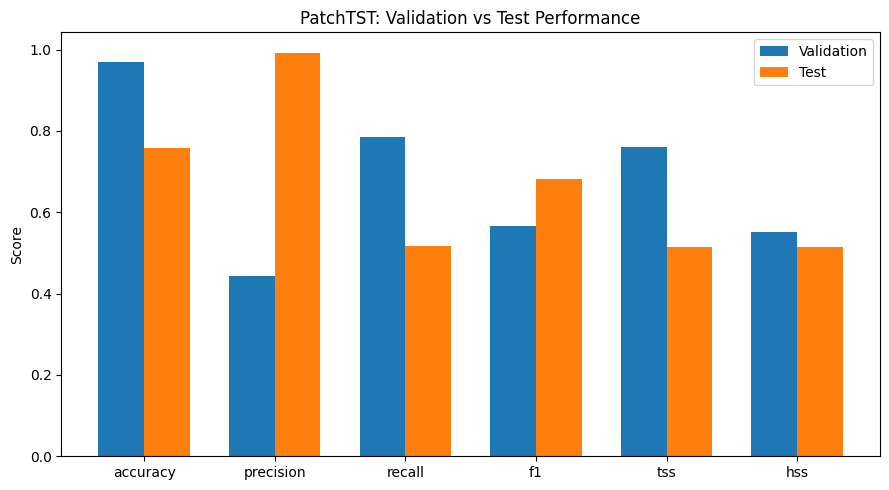

,train_part,test_part,patch_length,patch_stride,val_accuracy,val_precision,val_recall,val_f1,val_tss,val_hss,test_accuracy,test_precision,test_recall,test_f1,test_tss,test_hss
0,4,5,6,3,0.970448,0.442953,0.785714,0.566524,0.760817,0.552455,0.75838,0.992647,0.518182,0.680913,0.514381,0.515601


In [30]:
# Comparison DataFrame
comparison_df = pd.DataFrame([val_metrics, test_metrics]).set_index("split")
comparison_df

# Bar plot comparison
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "tss", "hss"]

plt.figure(figsize=(9, 5))
x = np.arange(len(metrics_to_plot))
width = 0.35

plt.bar(x - width/2, comparison_df.loc["validation", metrics_to_plot], width, label="Validation")
plt.bar(x + width/2, comparison_df.loc["test", metrics_to_plot], width, label="Test")

plt.xticks(x, metrics_to_plot)
plt.ylabel("Score")
plt.title("PatchTST: Validation vs Test Performance")
plt.legend()
plt.tight_layout()

bar_path = os.path.join(
    RESULTS_DIR,
    f"val_vs_test_train{CURRENT_TRAIN_PART}_test{CURRENT_TEST_PART}_p{patch_length}_s{patch_stride}.png"
)
plt.savefig(bar_path, dpi=200)
plt.show()

bar_path

# Save experiment summary
SUMMARY_DIR = "../reports/patchtst"
os.makedirs(SUMMARY_DIR, exist_ok=True)

summary_path = os.path.join(SUMMARY_DIR, "experiment_summary.csv")

row = {
    "train_part": CURRENT_TRAIN_PART,
    "test_part": CURRENT_TEST_PART,
    "patch_length": patch_length,
    "patch_stride": patch_stride,
    "val_accuracy": float(comparison_df.loc["validation", "accuracy"]),
    "val_precision": float(comparison_df.loc["validation", "precision"]),
    "val_recall": float(comparison_df.loc["validation", "recall"]),
    "val_f1": float(comparison_df.loc["validation", "f1"]),
    "val_tss": float(comparison_df.loc["validation", "tss"]),
    "val_hss": float(comparison_df.loc["validation", "hss"]),
    "test_accuracy": float(comparison_df.loc["test", "accuracy"]),
    "test_precision": float(comparison_df.loc["test", "precision"]),
    "test_recall": float(comparison_df.loc["test", "recall"]),
    "test_f1": float(comparison_df.loc["test", "f1"]),
    "test_tss": float(comparison_df.loc["test", "tss"]),
    "test_hss": float(comparison_df.loc["test", "hss"]),
}

if os.path.exists(summary_path):
    df = pd.read_csv(summary_path)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
else:
    df = pd.DataFrame([row])

df.to_csv(summary_path, index=False)
df.tail(10)


